# The project

## Team

Team members          | @polytechnique |
---                   | ---
Bruno Fernandes Iorio | bruno.fernandes-iorio
Adam Neveaux          | to be added
Daniela Cojocaru      | to be added

## Goals

  The aim of the project is to design a model for sentiment analysis. We consider a dataset of restaurant reviews (https://www.kaggle.com/datasets/joebeachcapital/restaurant-reviews), with reviews and rating. :


  The final goal that we intend for this model is to attribute a rating for a specific review, possibly for a restaurant, but not limited to it.

#Preliminaries

We start with important imports:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string


import sklearn
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD


from gensim.corpora import HashDictionary


In [ ]:

nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
SW = stopwords.words("english")
m = set(['no', 'nor', 'not',"hadn't","hasn","haven","isn", "shouldn't", "wasn't","weren't","weren","mustn't","wouldn",'too','very','don', "don't",'aren', "aren't",'didn', "didn't","isn't",'few','some','mightn', "mightn't", 'mustn', 'needn', "needn't", 'shan', "shan't", 'shouldn', 'wasn', 'won','more','most',"couldn't","doesn't","doesn","couldn","hadn","hasn't","haven't","havent","won't","wouln't","wouldn't"])
SW = [w for w in SW if w not in m]
print(SW)

Mounted at /content/drive
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'other', 'such', 'only', 'own', 'same', 'so', 'than', 's', 't', 'can', 'will', '

We get the dataset, and auxiliary datasets/lists/sets for the project

In [ ]:
data = pd.read_csv("/content/drive/My Drive/Restaurant reviews.csv")

pos_and_neg = pd.read_excel("/content/drive/My Drive/Positive and Negative Word List.xlsx")

neg = pos_and_neg["Negative Sense Word List"].copy() # dataframe with negative words
pos = pos_and_neg["Positive Sense Word List"].copy() # dataframe with positive words
poswords = [pos[i] for i in range(len(pos))]
negwords = [neg[i] for i in range(len(neg))]


negation_words = set(["no",'cant',"can't",'not',"isn't","isnt",'nobody', 'never','neither','nor','barely','hardly','scarcely','seldom','rarely','nothing', 'nor',"hadn't","hasn","haven","isn","shouldn", "shouldnt","shouldn't", "wasn't","wasnt","'t","n't","mustn't","mustn","weren't","weren","mustn't","wouldn",'don', "don't","dont",'aren',"arent", "aren't",'didn', "didnt","didn't","isn't","couldn't","doesn't","doesn","couldn","couldnt","hadn","havent","hasn't","haven't","havent","wasnt","wasn","wont","won't","wouldnt","wouln't","wouldn't"])
# set of words used for negation "not", "no", etc...

pos.dropna(inplace=True,ignore_index=True)
neg.dropna(inplace=True,ignore_index=True)


```data ``` contains the restaurant reviews.

```poswords``` is a dataframe containing positive sense words.

```negwords``` is a dataframe containing negative sense words.

```negation_words```is a set containing negation words.

# Cleaning data

In [ ]:

data_cleaned = data[['Review', 'Rating']] # just the important features
data_cleaned.dropna(inplace=True,ignore_index=True) # remove nan rows

data_train = data_cleaned[:-40]

data_test = data_cleaned[-40:]
data_test.dropna(inplace=True,ignore_index=True)

y = data_train[["Rating"]]


<ipython-input-5-4cb0cec62cbd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned.dropna(inplace=True,ignore_index=True) # remove nan rows
<ipython-input-5-4cb0cec62cbd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.dropna(inplace=True,ignore_index=True)


# Data pre-processing

## Preprocessing the Ratings

In [ ]:
def makeint(a):
  arr = a.copy()
  for i in range(len(arr)):
    if arr["Rating"][i] == 'Like':
      arr["Rating"][i] = 3
    if type(arr["Rating"][i]) is not int:
      arr["Rating"][i] = int(arr["Rating"][i][0])
    arr["Rating"][i] = int(arr["Rating"][i])
  return arr

The function ```makeint()``` corrects a few problems of the dataset, where one of the elements is the string "Like", instead of a number.


## Preprocessing the Reviews

In [ ]:

def getmax(X): ## useful for padding with 0's
  maxlen = 0
  for i in X:
    if len(i) > maxlen:
      maxlen = len(i)
  return maxlen

def remove_punc(a: pd.DataFrame) : ## remove punctuation
  df = a.copy()
  df["Review"] = df['Review'].str.replace(r'[^\w\s]','',regex=True)
  return df

def remove_stopwords_from_text(text) : #Remove useless words from teh text#
  tx = text.split()
  new_tx = " ".join([w for w in tx if not w in SW])
  return new_tx

def remove_stopwords(a: pd.DataFrame):
  df = a.copy()
  for i in range(len(df["Review"])):
    df["Review"][i] = remove_stopwords_from_text(df["Review"][i])
  return df

def find_most_freq(df: pd.DataFrame):
  freq = dict()
  for i in range(len(df["Review"])):
    for word in df["Review"][i].split():
      if word not in freq.keys():
        freq[word] = 0
      freq[word] += 1
  sort_freq = dict(sorted(freq.items(), key=lambda item: item[1])[:-1])
  return sort_freq

def remove_freq(a: pd.DataFrame,freq = None):
  df = a.copy()
  if freq is None:
    freq = find_most_freq(df)
  morefreq = list(freq.keys())[-35:]
  lessfreq = [w for w in list(freq.keys()) if freq[w] <= 50]
  for i in range(len(df["Review"])):
    text = df["Review"][i]
    text_list = text.split()
    new_text = " ".join([w for w in text_list if (w not in lessfreq)])
    df["Review"][i] = new_text
  return df


global_freq_dict = None
def preprocessing(a: pd.DataFrame):
  global global_freq_dict
  df = a.copy()
  df["Review"] = df['Review'].str.lower()
  df = remove_punc(df)
  df = remove_stopwords(df)
  if global_freq_dict is None:
    global_freq_dict = find_most_freq(df)
  df = remove_freq(df,global_freq_dict)
  for i in range(len(df)):
    df["Review"][i] = word_tokenize(df["Review"][i])
  return df


```getmax(X) ``` :  Returns the length of the biggest list in X. Useful for padding with zeros.

```remove_punc(a)```: Returns a dataframe where the Reviews have no punctuation

```remove_stop_words_from_text(text)```: Returns a text without the stopwords specified in ```SW```.

```remove_stopwords(a)``` Returns a dataframe where the Revuews don't have any of the stopwords specified in ```SW```.

``` find_most_freq(df) ``` : Returns a dictionary with the frequence of each word in the reviews dataset.

```remove_freq(a,freq=None)```: Remove words that are not frequent in the dataset, because they are not so relevant and make the dataset clearer.

``` global_freq_dict ``` : dictionary to be used with the frequences - set to None first , but modified after first iteration. (global variable)

``` preprocessing(a) ``` - apply all the functions above into the reviews and return a preprocessed dataset

## Applying the functions

In [ ]:
# dct = HashDictionary(debug=False)

y_new = makeint(y)
X_new = preprocessing(data_train)[["Review"]]


# print(dct.doc2bow([X_new]))



Now, ```X_new``` is our preprocessed data. Let's print it out:

In [ ]:
X_new

,Review
0,"[ambience, good, food, quite, good, saturday, ..."
1,"[ambience, too, good, pleasant, evening, servi..."
2,"[must, try, great, food, great, ambience, serv..."
3,"[great, guy, good, food, course, would, like, ..."
4,"[food, ordered, kodi, mutton, biryani, good, t..."
...,...
9910,"[good, food, specially, try, chicken, banana, ..."
9911,"[like, times, tried, chicken, schezwan, chicke..."
9912,"[authentic, chinese, food, takes, place, belie..."
9913,"[soon, restaurant, get, authentic, chinese, re..."


Let's also print ```y_new```

In [ ]:
y_new

,Rating
0,5
1,5
2,5
3,5
4,5
...,...
9910,4
9911,4
9912,3
9913,4


# Feature Extraction

In [ ]:
data_test_preprocessed = preprocessing(data_test)

## Extraction for Linear Regression

In [ ]:

X_new["features_linear"] = X_new["Review"]
#nltk.download('averaged_perceptron_tagger')


for i in range(len(X_new)):
  text = X_new["Review"][i]
  pos_word_count = sum(1 for word in text if word in poswords)
  neg_word_count = sum(1 for word in text if word in negwords)
 # pos_tags = pos_tag(text)
  #pos_counts = nltk.FreqDist(tag for (word, tag) in pos_tags)
  features = {

        'pos_word_count': pos_word_count,
        'neg_word_count': neg_word_count,
     #   'num_adjectives': pos_counts['JJ'] + pos_counts['JJR'] + pos_counts['JJS'],
     #   'num_adverbs': pos_counts['RB'] + pos_counts['RBR'] + pos_counts['RBS']
  }
  list_of_features = list(features.values())
  X_new["features_linear"][i] = list_of_features

X_final_Data = X_new.copy()

#def transformNumb(df):
  #X = []
  #maxlen = getmax(df["Review"])
  #for rev in df["Review"]:
    #row = np.zeros(maxlen)
    #for i in range(len(rev)):
      #if  rev[i] in poswords:
       # row[i] = 1
     # elif rev[i] in negwords:
      #  row[i] = -1
    #row.append(row[0]**2)
    #row.append(row[1]**2)

    #X.append(row)
  #return np.array(X)


In [ ]:

data_test_preprocessed["features_linear"] = data_test_preprocessed["Review"]
for i in range(len(data_test_preprocessed)):
  text = data_test_preprocessed["Review"][i]
  pos_word_count = sum(1 for word in text if word in poswords)
  neg_word_count = sum(1 for word in text if word in negwords)
  #pos_tags = pos_tag(text)
  #pos_counts = nltk.FreqDist(tag for (word, tag) in pos_tags)
  features = {

        'pos_word_count': pos_word_count,
        'neg_word_count': neg_word_count,
     #   'num_adjectives': pos_counts['JJ'] + pos_counts['JJR'] + pos_counts['JJS'],
     #   'num_adverbs': pos_counts['RB'] + pos_counts['RBR'] + pos_counts['RBS']
  }
  list_of_features = list(features.values())
  data_test_preprocessed["features_linear"][i] = list_of_features


## Extraction for the CNN model

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

With the code cell abov, we will be able to identify grammatical structures inside our texts with the function pos_tag.

In [ ]:
X_new["features_CNN"] = X_new["Review"]
for i in range(len(X_new)):
  text = X_new["Review"][i]
  tags = pos_tag(text)
  text_changed = np.zeros((getmax(X_new["Review"]),4))
  for j in range(len(tags)):
    if tags[j][0] in negation_words:
      text_changed[j,3] = 1
    elif tags[j][0] in poswords:
      text_changed[j,0] = 1
    elif tags[j][0] in negwords:
      text_changed[j,0] = -1

    if tags[j][1] in ["JJ","JJR","JJS"]: #adjectives
      text_changed[j,1] = 1
    if tags[j][1] in ["RB","RBR","RBS"]: #adverbs
      text_changed[j,2] = 1

  X_new["features_CNN"][i] = text_changed
X_new

,Review,features_linear,features_CNN
0,"[ambience, good, food, quite, good, saturday, ...","[7, 1]","[[0.0, 0.0, 1.0, 0.0], [1.0, 1.0, 0.0, 0.0], [..."
1,"[ambience, too, good, pleasant, evening, servi...","[8, 0]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [..."
2,"[must, try, great, food, great, ambience, serv...","[6, 0]","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
3,"[great, guy, good, food, course, would, like, ...","[5, 0]","[[1.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
4,"[food, ordered, kodi, mutton, biryani, good, t...","[6, 0]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
...,...,...,...
9910,"[good, food, specially, try, chicken, banana, ...","[11, 1]","[[1.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
9911,"[like, times, tried, chicken, schezwan, chicke...","[9, 1]","[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
9912,"[authentic, chinese, food, takes, place, belie...","[9, 3]","[[1.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [..."
9913,"[soon, restaurant, get, authentic, chinese, re...","[9, 0]","[[0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0], [..."


In [ ]:
data_test_preprocessed["features_CNN"] = data_test_preprocessed["Review"]
for i in range(len(data_test_preprocessed)):
  text = data_test_preprocessed["Review"][i]
  tags = pos_tag(text)
  text_changed = np.zeros((getmax(X_new["Review"]),4))
  for j in range(len(tags)):
    if tags[j][0] in negation_words:
      text_changed[j,3] = 1
    elif tags[j][0] in poswords:
      text_changed[j,0] = 1
    elif tags[j][0] in negwords:
      text_changed[j,0] = -1

    if tags[j][1] in ["JJ","JJR","JJS"]: #adjectives
      text_changed[j,1] = 1
    if tags[j][1] in ["RB","RBR","RBS"]: #adverbs
      text_changed[j,2] = 1

  data_test_preprocessed["features_CNN"][i] = text_changed
data_test_preprocessed

,Review,Rating,features_linear,features_CNN
0,"[recently, visited, place, decor, simple, yet,...",3,"[4, 0]","[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
1,"[place, long, time, wanted, pay, visit, finall...",3,"[18, 5]","[[0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [..."
2,"[really, loved, ambience, staff, very, polite,...",4,"[7, 1]","[[1.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
3,"[place, food, gachibowli, hyderabad, soup, rea...",4,"[8, 1]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
4,"[good, ambience, presentation, thai, flavor, v...",4,"[8, 0]","[[1.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
5,"[told, one, place, found, amazing, first, gach...",4.5,"[30, 0]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
6,"[one, chinese, restaurants, perfect, quiet, di...",4.5,"[4, 0]","[[0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [..."
7,"[tried, prawn, pepper, chinese, special, veg, ...",3,"[9, 3]","[[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
8,"[chinese, used, regular, favourite, days, visi...",5,"[10, 0]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."
9,"[restaurant, serving, chinese, cuisine, gachib...",3,"[11, 1]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."


In [ ]:
for i in range(10):
  print(pos_tag(X_new["Review"][9900])[i],X_new["features_CNN"][9900][i])
X_CNN = np.array([X_new["features_CNN"][i] for i in range(len(X_new["features_CNN"]))])
print(np.shape(X_CNN[0]))

('food', 'NN') [0. 0. 0. 0.]
('chinese', 'JJ') [0. 1. 0. 0.]
('indian', 'JJ') [0. 1. 0. 0.]
('enjoyed', 'VBN') [1. 0. 0. 0.]
('taste', 'NN') [0. 0. 0. 0.]
('service', 'NN') [1. 0. 0. 0.]
('order', 'NN') [0. 0. 0. 0.]
('us', 'PRP') [0. 0. 0. 0.]
('different', 'JJ') [1. 1. 0. 0.]
('dish', 'JJ') [0. 1. 0. 0.]
(389, 4)


#The model

## Linear Regression model

This is our simplest model. I just takes into consideration the number of positive and negative words of a given text, and apply a regression on this. We justify this approach with the following plot:

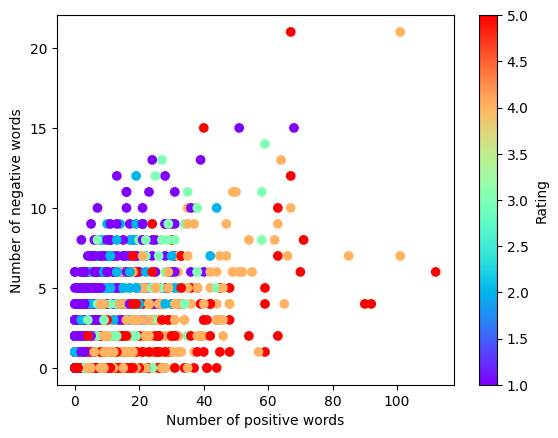

In [ ]:
X_regression = np.array([X_new["features_linear"][i]for i in range(len(X_new))])
y_map = [float(y_new["Rating"][i]) for i in range(len(y_new["Rating"]))]
## plots
plt.scatter(x=X_regression[:,0],y=X_regression[:,1],c=y_map,cmap="rainbow")
plt.xlabel("Number of positive words")
plt.ylabel("Number of negative words")
plt.colorbar(label="Rating")
plt.show()

As we can see from the plot, the more positve words and less negative words, the higher the rating in average. We can, then, approximate the distribution linearly in the 3d space. But still it is very hard to cluster the in between scores.

In [ ]:
def linear_Regression_model():
  model = sklearn.linear_model.LinearRegression()
  return model


In [ ]:
model_regression = linear_Regression_model()
model_regression.fit(X_regression,y_new)


LinearRegression()

In [ ]:
test_linear = np.array([data_test_preprocessed["features_linear"][i] for i in range(len(data_test_preprocessed))])
pred = model_regression.predict(test_linear)
for i in range(len(test_linear)):
  print(i)
  print("predicted: ", pred[i])
  print("actual: ", data_test_preprocessed["Rating"][i])


0
predicted:  [3.92929934]
actual:  3
1
predicted:  [2.29944978]
actual:  3
2
predicted:  [3.61978567]
actual:  4
3
predicted:  [3.70206688]
actual:  4
4
predicted:  [4.2584242]
actual:  4
5
predicted:  [6.06861092]
actual:  4.5
6
predicted:  [3.92929934]
actual:  4.5
7
predicted:  [2.67163348]
actual:  3
8
predicted:  [4.42298662]
actual:  5
9
predicted:  [3.94891053]
actual:  3
10
predicted:  [1.98609966]
actual:  3.5
11
predicted:  [4.17614298]
actual:  4.5
12
predicted:  [4.2584242]
actual:  4
13
predicted:  [2.81658471]
actual:  3
14
predicted:  [2.81658471]
actual:  3.5
15
predicted:  [1.70387009]
actual:  5
16
predicted:  [3.61978567]
actual:  4
17
predicted:  [5.49264241]
actual:  4.5
18
predicted:  [2.98114714]
actual:  3
19
predicted:  [4.17614298]
actual:  4
20
predicted:  [3.86662931]
actual:  5
21
predicted:  [2.13488735]
actual:  4.5
22
predicted:  [4.03119174]
actual:  4
23
predicted:  [3.29066081]
actual:  5
24
predicted:  [3.61978567]
actual:  4.5
25
predicted:  [3.494

## CNN model

In [ ]:
def CNN_model(input_shape):
  model = tf.keras.Sequential()

  model.add(Conv2D(filters=10,kernel_size=(4,4),padding='valid',activation="relu", input_shape=input_shape))
  model.add(Conv2D(filters=10,kernel_size=(4,1),padding='valid',activation="relu", input_shape=input_shape))

  model.add(MaxPooling2D(pool_size=(4,1)))
  model.add(Dropout(rate=0.25))
  model.add(BatchNormalization())


  model.add(Conv2D(filters=25,kernel_size=(4,1),padding='valid',activation="relu", input_shape=input_shape))
  model.add(Conv2D(filters=25,kernel_size=(4,1),padding='valid',activation="relu", input_shape=input_shape))

  model.add(MaxPooling2D(pool_size=(4,1)))
  model.add(Dropout(rate=0.25))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=50,kernel_size=(4,1),padding='valid',activation="relu", input_shape=input_shape))
  model.add(Conv2D(filters=50,kernel_size=(4,1),padding='valid',activation="relu", input_shape=input_shape))


  model.add(MaxPooling2D(pool_size=(2,1)))
  model.add(Dropout(rate=0.25))
  model.add(BatchNormalization())

  model.add(Flatten())

  model.add(Dense(512, activation='relu'))

  model.add(Dense(256, activation='relu'))

  model.add(Dense(128, activation='relu'))



  model.add(Dense(5,activation='softmax'))
  model.compile(loss='categorical_crossentropy',
    optimizer='SGD',
    metrics=['accuracy'])
  return model


In [ ]:
model_cnn = CNN_model((389,4,1))
model_cnn.summary()

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_266 (Conv2D)         (None, 386, 1, 10)        170       
                                                                 
 conv2d_267 (Conv2D)         (None, 383, 1, 10)        410       
                                                                 
 max_pooling2d_129 (MaxPool  (None, 95, 1, 10)         0         
 ing2D)                                                          
                                                                 
 dropout_174 (Dropout)       (None, 95, 1, 10)         0         
                                                                 
 batch_normalization_158 (B  (None, 95, 1, 10)         40        
 atchNormalization)                                              
                                                                 
 conv2d_268 (Conv2D)         (None, 92, 1, 25)       

In [ ]:
y_map = np.array(y_map)
z = y_map.copy()
for i in range(len(y_map)):
  z[i] = int(y_map[i])-1

y_CNN = keras.utils.to_categorical(z, num_classes=5)
model_cnn.fit(X_CNN,y_CNN,epochs=10)

Epoch 1/10
310/310 [==============================] - 10s 26ms/step - loss: 1.4874 - accuracy: 0.3823
Epoch 2/10
310/310 [==============================] - 10s 33ms/step - loss: 1.4270 - accuracy: 0.4188
Epoch 3/10
310/310 [==============================] - 9s 29ms/step - loss: 1.3248 - accuracy: 0.4707
Epoch 4/10
310/310 [==============================] - 9s 30ms/step - loss: 1.2611 - accuracy: 0.4919
Epoch 5/10
310/310 [==============================] - 10s 33ms/step - loss: 1.2205 - accuracy: 0.5034
Epoch 6/10
310/310 [==============================] - 8s 26ms/step - loss: 1.1930 - accuracy: 0.5151
Epoch 7/10
310/310 [==============================] - 13s 42ms/step - loss: 1.1762 - accuracy: 0.5247
Epoch 8/10
310/310 [==============================] - 10s 33ms/step - loss: 1.1716 - accuracy: 0.5289
Epoch 9/10
310/310 [==============================] - 8s 27ms/step - loss: 1.1637 - accuracy: 0.5299
Epoch 10/10
310/310 [==============================] - 10s 34ms/step - loss: 1.1626 - 

In [ ]:
to_predict_cnn = np.array([data_test_preprocessed["features_CNN"][i] for i in range(len(data_test_preprocessed["features_CNN"]))])

prediction_CNN = model_cnn.predict(to_predict_cnn)
print(data_test["Review"][23])
pred = []
for guess in prediction_CNN:
  for j in range(len(guess)):
    if guess[j] == max(guess):
      guess[j]=1
      pred.append(j)
    else:
      guess[j]=0
for i in range(len(data_test_preprocessed["Rating"])):
  if type(data_test_preprocessed["Rating"][i]) is str:
    data_test_preprocessed["Rating"][i] = data_test_preprocessed["Rating"][i][0]
  data_test_preprocessed["Rating"][i] = int(data_test_preprocessed["Rating"][i])
data_test_preprocessed["Rating"][i]
t = 0
for i in range(len(pred)):
  print(str(i) + ") predicted and real rating: ", pred[i]+1, int(data_test_preprocessed["Rating"][i]), abs(pred[i] +1 - int(data_test_preprocessed["Rating"][i])) )
  if abs(pred[i] +1 - int(data_test_preprocessed["Rating"][i])) <= 2:
    t += 1
print(t)


2/2 [==============================] - 0s 19ms/step
What a delightful place. Food was the star here and we were left literally grinning ear to ear by the end of it all. A feat considering how grumpy I was at prospect of consuming vegetarian food on account of Ganesh Chaturthy. But one sip of Vietnamese noodles soup later we were already celebrating. Halfway into Thai red curry/steamed rice I had already activated my man-vs-food mode but it all abruptly ended after my wife swiftly got everything parcelled. Happy.
0) predicted and real rating:  5 3 2
1) predicted and real rating:  1 3 2
2) predicted and real rating:  4 4 0
3) predicted and real rating:  4 4 0
4) predicted and real rating:  5 4 1
5) predicted and real rating:  4 4 0
6) predicted and real rating:  5 4 1
7) predicted and real rating:  1 3 2
8) predicted and real rating:  5 5 0
9) predicted and real rating:  4 3 1
10) predicted and real rating:  4 3 1
11) predicted and real rating:  5 4 1
12) predicted and real rating:  5 4 

In [ ]:
##Positive-Negative word list separation, into Decision Tree

##ALL SORTA decision tree ideas getting tested here:

#dtree = DecisionTreeClassifier(criterion="log_loss", max_leaves=15)



'Really loved the ambience. Staff was very polite. Very delicious food served quickly though it was busy. But very expensive when compared to other restaurants.'

In [ ]:
#bruno, I tried bayes for over three hours,


In [ ]:



# def based_bayes_model_fit(X, y, verbose=True):



# def based_bayes_model_predict(X, weights):
#   return pass

IndentationError: expected an indented block after function definition on line 1 (<ipython-input-15-709851a421be>, line 5)